## Import libraries

In [3]:
import pandas as pd
from collections import defaultdict
from transformers import pipeline
from tqdm import tqdm
import pickle
import sklearn
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import scikitplot as skplt


In [1]:
!pip install -U scikit-learn
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


## Import clean tweets

In [4]:
df = pd.read_csv("./csv/df_pointet_translated_tweets_clean.csv")

In [5]:
df

,Unnamed: 0,tweets,time,language,translated_tweets
0,0,"Intéressant, même si ces graphiques se basent ...",2022-12-13 09:03:59+00:00,"((0, 73, 'FRENCH', 'fr'),)","Interesting, even if these graphs are based on..."
1,1,"Montrer les muscles n'est jamais la solution, ...",2022-12-13 07:44:26+00:00,"((0, 218, 'FRENCH', 'fr'),)","Showing muscles is never the solution, you hav..."
2,2,Pour une Suisse forte avec l'Europe.\naucoeurd...,2022-12-06 07:52:00+00:00,"((0, 53, 'FRENCH', 'fr'),)",For a strong Switzerland with Europe. aucoeurd...
3,3,Cela ne va pas très vite entre Fribourg et Lau...,2022-12-01 15:03:16+00:00,"((0, 55, 'FRENCH', 'fr'),)",It doesn't go very fast between Fribourg and L...
4,4,"Dans les conflits du monde entier, ce sont sou...",2022-11-28 14:27:05+00:00,"((0, 257, 'FRENCH', 'fr'),)","In conflicts around the world, it is often the..."
...,...,...,...,...,...
992,992,"Demain, jom, deux cobayes pour faire du scratc...",2013-11-13 10:51:40+00:00,"((0, 50, 'FRENCH', 'fr'),)","Tomorrow, jom, two guinea pigs to make scratch..."
993,993,Les 10km du marathon de lausanne en moins de u...,2013-10-27 11:39:02+00:00,"((0, 124, 'FRENCH', 'fr'),)",The 10km of the Lausanne marathon in less than...
994,994,"Keynote sos13, utiliser sans comprendre commen...",2013-10-25 07:41:42+00:00,"((0, 116, 'FRENCH', 'fr'),)","Keynote sos13, to use without understanding ho..."
995,995,"noSQL, c'est quoi la strategie des gens qui fo...",2013-10-25 06:44:38+00:00,"((0, 92, 'FRENCH', 'fr'),)","NoSQL, what is the strategy of people who do g..."


## Create topics to keywords

In [6]:
topics_to_keyword = {}
topics_to_keyword['family'] = {'pension', 'AHV', 'AVS', 'benefit', 'benefits', 'childcare', 'nursery', 'paternity', 'pension', 'life expectancy', 'social assistance', 'social housing', 'construction', 'public housing'}
topics_to_keyword['health'] = {'health', 'premium', 'organ', 'donation', 'vaccine', 'vaccination', 'insurance', 'premium', 'subsidies', 'cost brake', 'health care cost'}
topics_to_keyword['education'] = {'education', 'courses', 'subsidies', 'religion', 'sex education', 'reconversion', 'learning', 'school', 'highschool', 'apprenticeship', 'disabilities'}
topics_to_keyword['immigration'] = {'resident', 'communal elections', 'bilateral', 'EU', 'immigration', 'foreigners', 'undocumented', 'residence', 'migrants', 'asylum', 'naturalisation', 'integration'}
topics_to_keyword['finances'] = {'taxes', 'financial equalisation', 'individual taxation', 'married', 'company taxation'}
topics_to_keyword['economy'] = {'electricity', 'wage', 'FDI', 'investment controls', 'takeovers', 'opening hours', 'shops', 'dismissal', 'workers', ' public services', 'post office'}
topics_to_keyword['digitalisation'] = {'Uber', 'Airbnb', 'online'}
topics_to_keyword['energy'] = {'fossil', 'fuel', 'C02', 'gas', 'renewable', 'energy', 'motorway', 'lanes', 'road pricing'}
topics_to_keyword['ecology'] = {'predators', 'lynx', 'bears', 'wolf', 'plants', 'genetically modified', 'ecologica', 'farms', 'pesticides', 'biodiversity', 'animals', 'livestock'}
topics_to_keyword['politics'] = {'campaigns', 'transparency', 'e-voting', 'votes', 'voting age'}
topics_to_keyword['security'] = {'border control', 'civil service', 'schengen', 'shengen', 'war', 'weapons', 'army', 'aircraft', 'dna'}
topics_to_keyword['external_relations'] = {'EU', 'trade', 'USA', 'human rights', 'environment', 'security council'}
topics_to_keyword['society'] = {'cannabis', 'homosexual', 'gay', 'lesbian', 'reproduction', 'equality', 'salaries', 'doctor', 'euthanasia'}



In [7]:
#save it to pickle
with open('topics.pickle', 'wb') as handle:
    pickle.dump(topics_to_keyword, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
#assign topics to tweets
classes = [set() for _ in range(len(df))]

for i,tweet in enumerate(df["translated_tweets"]):
    for topic in topics_to_keyword:
        for keyword in topics_to_keyword[topic]:
            if keyword in tweet:
                classes[i].add(topic)
        

In [9]:
df["topic"] = classes

### how many sentences without a topic?

In [10]:
res = 0
for topic in df['topic']:
    if len(topic) == 0:
        res += 1

print(res)
# many sentences without topic

826


# Import questions and create context tweets

In [11]:
df

,Unnamed: 0,tweets,time,language,translated_tweets,topic
0,0,"Intéressant, même si ces graphiques se basent ...",2022-12-13 09:03:59+00:00,"((0, 73, 'FRENCH', 'fr'),)","Interesting, even if these graphs are based on...",{}
1,1,"Montrer les muscles n'est jamais la solution, ...",2022-12-13 07:44:26+00:00,"((0, 218, 'FRENCH', 'fr'),)","Showing muscles is never the solution, you hav...",{}
2,2,Pour une Suisse forte avec l'Europe.\naucoeurd...,2022-12-06 07:52:00+00:00,"((0, 53, 'FRENCH', 'fr'),)",For a strong Switzerland with Europe. aucoeurd...,{}
3,3,Cela ne va pas très vite entre Fribourg et Lau...,2022-12-01 15:03:16+00:00,"((0, 55, 'FRENCH', 'fr'),)",It doesn't go very fast between Fribourg and L...,{}
4,4,"Dans les conflits du monde entier, ce sont sou...",2022-11-28 14:27:05+00:00,"((0, 257, 'FRENCH', 'fr'),)","In conflicts around the world, it is often the...",{}
...,...,...,...,...,...,...
992,992,"Demain, jom, deux cobayes pour faire du scratc...",2013-11-13 10:51:40+00:00,"((0, 50, 'FRENCH', 'fr'),)","Tomorrow, jom, two guinea pigs to make scratch...",{}
993,993,Les 10km du marathon de lausanne en moins de u...,2013-10-27 11:39:02+00:00,"((0, 124, 'FRENCH', 'fr'),)",The 10km of the Lausanne marathon in less than...,{}
994,994,"Keynote sos13, utiliser sans comprendre commen...",2013-10-25 07:41:42+00:00,"((0, 116, 'FRENCH', 'fr'),)","Keynote sos13, to use without understanding ho...",{}
995,995,"noSQL, c'est quoi la strategie des gens qui fo...",2013-10-25 06:44:38+00:00,"((0, 92, 'FRENCH', 'fr'),)","NoSQL, what is the strategy of people who do g...",{}


In [14]:
#import csv
df_questions = pd.read_csv('./csv/pointet_questions.csv', sep=';', encoding='latin-1' )

In [15]:
#convert answers to binary
df_questions["questions"] = df_questions['questions'].str[4:-2]
df_questions.loc[df_questions['smartvote_answers'] >= 3, 'binary_smarvote_answer'] = 0
df_questions.loc[df_questions['smartvote_answers'] <= 2, 'binary_smarvote_answer'] = 1

In [16]:
topics = ["family", "health", "education", "immigration", "finances", "economy", "digitalisation", "energy", "ecology", "politics", "security", "external_relations", "society"]

In [17]:
tweets_with_topic = defaultdict(list)

In [18]:
for i in range(len(df)):
    if df.iloc[i]['topic']:
        for topic in df.iloc[i]['topic']:
            tweets_with_topic[topic].append(df.iloc[i]['translated_tweets'])
        

In [19]:
context_tweets = {}

In [20]:
#join context tweets
for topic in topics:
    context_tweets[topic] = ''.join(tweets_with_topic[topic])

In [21]:
df_questions

,questions,smartvote_answers,Simplified question,Unnamed: 3,Topic,Keywords,binary_smarvote_answer
0,tes-vous favorable à une hausse de l'âge de la...,1,''Are you in favour of raising the retirement ...,NaN,Family,pension; AHV; AVS,1.0
1,'État devrait-il renforcer son soutien financi...,3,''Should the state support childcare? '',NaN,Family,benefit; childcare; nursery,0.0
2,ne initiative demande l'instauration d'un cong...,1,''Are you in favour of a paternity leave?'',NaN,Family,paternity; leave,1.0
3,es rentes de la caisse de pension doivent-elle...,1,''Should the finance state pension funds?'',NaN,Family,pension; life expectancy,1.0
4,outenez-vous les efforts au niveau des cantons...,3,''Are you in favor of benefits?'',NaN,Family,benefits; social assistance,0.0
5,a Confédération devrait-elle encourager davant...,3,''Are you in favor of public housing?'',NaN,Family,social housing; construction; public housing,0.0
6,es personnes assurées devraient-elles contribu...,2,''Should the health insurance cost more'',NaN,Health,health cost; health care cost; premium,1.0
7,pprouveriez-vous le principe du consentement p...,2,''Is organ donation good?'',NaN,Health,organ; donation,1.0
8,"ne vaccination obligatoire des enfants, basée ...",2,''Should vaccines be compulsory? '',NaN,Health,vaccine; vaccination,1.0
9,ne initiative demande que les subsides aux ass...,4,''Should health be proportional to your income?'',NaN,Health,insurance; premium; subsidies,0.0


## QA model

In [22]:
qa_model = pipeline("question-answering", model = "deepset/roberta-base-squad2")
#qa_model(question = question_paternity_leave, context = context_tweets_all)

In [23]:
huggingface_answers = []
for i in tqdm(range(len(df_questions))):
    question = df_questions.iloc[i]['Simplified question']
    context = context_tweets[df_questions.iloc[i]['Topic'].lower()]
    if not context:
        huggingface_answers.append({'score':0, 'start':0, 'end':0, 'answer':'N/A'})
    else:
        huggingface_answers.append(qa_model(question = question, context = context))


100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


In [25]:
df_questions["huggingface_answers"] = huggingface_answers

In [26]:
df_questions.to_csv("./csv/df_pointet_questions_context.csv" )

#0 negative
#1 positive
#2 no answers

In [28]:
df_questions_context_cami=pd.read_csv("./csv/pointet_cami_label.csv", delimiter = ';')

In [29]:
#df_questions_context_all_cami=pd.read_csv("./csv/df_questions_context_all_cami_label.csv", delimiter = ';')

In [31]:
df_questions_context_cami.iloc[28]['Simplified question']

'"Do you believe in individual taxation?"'

In [32]:
df_questions_context_cami.iloc[28]['huggingface_answers']

"{'score': 0.006144154351204634, 'start': 829, 'end': 872, 'answer': 'individual taxation is what we need to hear'}"

In [33]:
df_questions_context_cami.iloc[28]['cami_answers']

1

In [34]:
df_questions_context_cami.iloc[28]['binary_smarvote_answer']

1

In [35]:
df_questions_context_cami



,Column1,questions,smartvote_answers,Simplified question,Unnamed: 3,Topic,Keywords,binary_smarvote_answer,huggingface_answers,cami_answers
0,0,tes-vous favorable à une hausse de l'âge de la...,1,''Are you in favour of raising the retirement ...,NaN,Family,pension; AHV; AVS,1,"{'score': 0.11170733720064163, 'start': 321, '...",2
1,1,'État devrait-il renforcer son soutien financi...,3,''Should the state support childcare? '',NaN,Family,benefit; childcare; nursery,0,"{'score': 0.0915219858288765, 'start': 321, 'e...",2
2,2,ne initiative demande l'instauration d'un cong...,1,''Are you in favour of a paternity leave?'',NaN,Family,paternity; leave,1,"{'score': 0.07459041476249695, 'start': 321, '...",2
3,3,es rentes de la caisse de pension doivent-elle...,1,''Should the finance state pension funds?'',NaN,Family,pension; life expectancy,1,"{'score': 0.03930806368589401, 'start': 321, '...",2
4,4,outenez-vous les efforts au niveau des cantons...,3,''Are you in favor of benefits?'',NaN,Family,benefits; social assistance,0,"{'score': 0.04316568747162819, 'start': 321, '...",2
5,5,a Confédération devrait-elle encourager davant...,3,''Are you in favor of public housing?'',NaN,Family,social housing; construction; public housing,0,"{'score': 0.2207994908094406, 'start': 321, 'e...",2
6,6,es personnes assurées devraient-elles contribu...,2,''Should the health insurance cost more'',NaN,Health,health cost; health care cost; premium,1,"{'score': 0.039787426590919495, 'start': 2894,...",0
7,7,pprouveriez-vous le principe du consentement p...,2,''Is organ donation good?'',NaN,Health,organ; donation,1,"{'score': 0.14415423572063446, 'start': 2428, ...",2
8,8,"ne vaccination obligatoire des enfants, basée ...",2,''Should vaccines be compulsory? '',NaN,Health,vaccine; vaccination,1,"{'score': 0.033538222312927246, 'start': 1090,...",2
9,9,ne initiative demande que les subsides aux ass...,4,''Should health be proportional to your income?'',NaN,Health,insurance; premium; subsidies,0,"{'score': 0.07606954872608185, 'start': 1765, ...",2


# Generate Word Cloud

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


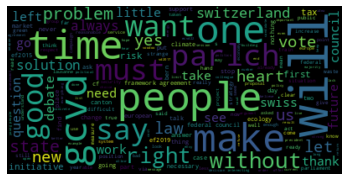

In [37]:
#remove stopwords??

# First, you will need to install the WordCloud library
!pip install wordcloud
import re
# Next, import the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the text of the tweets from the dataframe
tweet_text = df['translated_tweets'].tolist()


# Pre-process the text to remove any unwanted characters or words
def preprocess_text(text):
  # Remove hashtags, mentions, and URLs
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'http\S+', '', text)

  # Convert to lowercase and remove any extra whitespace
  text = text.lower().strip()
  return text

tweet_text = [preprocess_text(text) for text in tweet_text]

# Join the text into a single string
text = ' '.join(tweet_text)

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Evaluation individual context Tweets

In [38]:
# First, you will need to install the WordCloud library
!pip install wordcloud

# Next, import the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get the text of the tweets from the dataframe
tweet_text = dataframe['tweet_text'].tolist()

# Pre-process the text to remove any unwanted characters or words
def preprocess_text(text):
  # Remove hashtags, mentions, and URLs
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'http\S+', '', text)
  # Convert to lowercase and remove any extra whitespace
  text = text.lower().strip()
  return text

tweet_text = [preprocess_text(text) for text in tweet_text]

# Join the text into a single string
text = ' '.join(tweet_text)

# Generate the wordcloud
wordcloud = WordCloud().generate(text)

# Display the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


NameError: name 'dataframe' is not defined

In [39]:
#might not make sense
sklearn.metrics.f1_score(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"], average=None)

array([0.        , 0.34782609, 0.        ])

In [40]:
sklearn.metrics.confusion_matrix(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"])

array([[ 0,  2, 22],
       [ 1,  8, 27],
       [ 0,  0,  0]])

[[ 0  2 22]
 [ 1  8 27]
 [ 0  0  0]]


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator


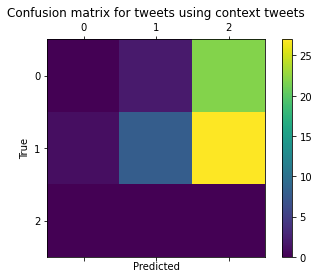

In [41]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', 2]
cm = confusion_matrix(df_questions_context_cami["binary_smarvote_answer"], df_questions_context_cami["cami_answers"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for tweets using context tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [42]:
# high number of unclassified, 39 as seen in the confusion matrix
#show an example from the df
#challenge: how to increase? he might not have tweeted

#otherwise for the classified, good performance
#what he says is what he thinks

### what is an unclassified tweet?

In [43]:
df_questions_context_cami.iloc[46]["Simplified question"]

'"Should biodiversity protection measures be extended?"'

In [44]:
df_questions_context_cami.iloc[46]["huggingface_answers"]

"{'score': 0.00011242137406952679, 'start': 818, 'end': 837, 'answer': 'ecological taxation'}"

In [45]:
df_questions_context_cami.iloc[39]["Simplified question"]

'"Should fuel be taxed?"'

In [46]:
df_questions_context_cami.iloc[39]["huggingface_answers"]

"{'score': 0.2358008325099945, 'start': 1745, 'end': 1793, 'answer': 'The solution cannot be to subsidise fossil fuels'}"

# Evaluation tweets all context

In [47]:
#super slow

In [48]:
#sklearn.metrics.f1_score(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"], average=None)

In [49]:
sklearn.metrics.confusion_matrix(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"])

NameError: name 'df_questions_context_all_cami' is not defined

In [50]:
#46 unclassified, higher than individual context vector
# according to this model, carlo is not truthful

In [51]:
from sklearn.metrics import confusion_matrix

labels = ['0', '1', '2']
cm = confusion_matrix(df_questions_context_all_cami["binary_smarvote_answer"], df_questions_context_all_cami["cami_answers"])
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix for Tweets using All tweets')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'df_questions_context_all_cami' is not defined

# Questions

1. what if carlo hasn't tweeted about a question? Then the model can't generate answers
2. suggestion to improve non-classified answers?
3. suggestion: add more keywords_to_tweets for more text in context (not sure)